# 2-class KNN classification

This exercise is trying to accomplish the following:

- it is assumed you already have a dataset that has been normalized with min-max to scale all the features from 0..1
- dataset contains two classes (normal, abnormal) 
- 2000 rows of normal data, 200 rows of abnormal data
- The procedure is shown in the graphic below. Both the normal traffic and the anomaly traffic data are downsampled to, on the one hand, keep some anomaly traffic for the final validation stage; on the second hand, the downsampling allows us to obtain a balanced data set for training the two-classes problems.
- The remaining data not used in the training and testing of the models is preserved for the final validation stage.
- Once the data is downsampled, it is normalized and a 10-fold cross validation is carried out independently for the two-classes problem and for the one-class problem, although the same random seed is used to obtain the same partitions in each case for comparison reasons. 
- In the two-classes problem, all the partitions may include normal and anomaly instances. However, in the one-class problem, the partitions are prepared only with the normal traffic instances; the anomaly instances are used to measure the performance of the models obtained for each fold. Interestingly, the normalization for the one-class problem is determined exclusively with data from normal traffic only.
- A final validation stage includes all the data that has not been used in training and testing; this is an unbalanced data set containing instances from normal traffic and from anomalies. 
- The aim of this validation stage is to compare the behavior of the different modeling techniques included in this comparison, so conclusions could be extracted.



## Design of experiment
<img src=https://raw.githubusercontent.com/nickjeffrey/sklearn/master/images/fig03_experimental_setup.png>

In [125]:
# Based on # Stat479: Machine Learning -- L02: kNN in Python
# https://github.com/rasbt/stat479-machine-learning-fs18/blob/master/02_knn/02_knn_demo.ipynb
# uses my own custom dataset instead of the provided iris dataset

# 0 - General Imports



In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1 - Load Dataset into a Pandas DataFrame


In [127]:
#df_data = pd.read_csv('c:/temp/data4.csv')
df_data = pd.read_csv('https://raw.githubusercontent.com/nickjeffrey/sklearn/master/dataset.csv')

In [128]:
# look at the top few rows of the data (should show the abnormal class in column 35)
df_data.head()

,seconds_since_epoch,datestamp,sp1_watts_generated,sp2_watts_generated,sp3_watts_generated,iot_gateway_watt_consumption,water_pump_watt_consumption,valve1_watt_consumption,valve2_watt_consumption,valve3_watt_consumption,...,temps3_soil_temperature_C,latency_iotgateway_ms,latency_logcollector_ms,packetloss_iotgateway,packetloss_logcollector,auth_success_mqtt_to_hmi,auth_failure_mqtt_to_hmi,auth_success_ssh_to_iogateway,auth_failure_ssh_to_iotgateway,class
0,1673118019,12:00,0.567684,0.372796,0.190634,0.431138,0.152043,0.22,0.03,0.01,...,0.134066,0.177232,0.361515,0.335616,0.169168,0.50,0.35,0.363636,0.181818,abnormal
1,1673118079,12:01,0.991496,0.195312,0.554051,0.041916,0.469952,0.46,0.95,0.95,...,0.513187,1.000000,0.432054,0.568493,0.221010,0.90,0.50,0.363636,0.090909,abnormal
2,1673118139,12:02,0.561081,0.682893,0.070798,0.514970,0.364784,0.97,0.01,0.03,...,0.532143,0.415912,0.294087,0.053425,0.072306,0.70,0.05,0.363636,0.818182,abnormal
3,1673118199,12:03,0.756478,0.173478,0.698055,0.544910,0.995192,0.21,0.00,0.00,...,0.607967,0.628072,0.297199,0.446575,0.084584,0.10,0.15,0.181818,0.818182,abnormal
4,1673118259,12:04,0.794297,0.157652,0.379362,0.934132,0.270433,0.14,0.01,0.80,...,0.121429,0.454075,0.705913,0.375342,0.436562,0.45,0.25,0.090909,0.181818,abnormal


In [129]:
# look at the bottom few rows of the data (should show the normal class in column 35)
df_data.tail()

,seconds_since_epoch,datestamp,sp1_watts_generated,sp2_watts_generated,sp3_watts_generated,iot_gateway_watt_consumption,water_pump_watt_consumption,valve1_watt_consumption,valve2_watt_consumption,valve3_watt_consumption,...,temps3_soil_temperature_C,latency_iotgateway_ms,latency_logcollector_ms,packetloss_iotgateway,packetloss_logcollector,auth_success_mqtt_to_hmi,auth_failure_mqtt_to_hmi,auth_success_ssh_to_iogateway,auth_failure_ssh_to_iotgateway,class
2195,1673108106,9:15,30.52,28.03,29.16,0.90,0.0,0.22,0.18,0.18,...,20.2,0.347,0.652,0.0,0.0,1.0,0.0,4.0,0.0,normal
2196,1673108166,9:16,29.15,32.25,28.14,0.85,0.0,0.19,0.18,0.19,...,20.0,0.406,0.493,0.0,0.0,1.0,0.0,6.0,0.0,normal
2197,1673108226,9:17,27.38,31.66,28.55,0.91,0.0,0.20,0.22,0.22,...,19.0,0.492,0.561,0.0,0.0,1.0,0.0,2.0,0.0,normal
2198,1673108286,9:18,29.90,29.17,31.15,0.88,0.0,0.23,0.18,0.18,...,20.2,0.347,0.510,0.0,0.0,1.0,0.0,1.0,0.0,normal
2199,1673108346,9:19,31.18,32.28,30.99,0.81,0.0,0.16,0.18,0.23,...,20.8,0.529,0.442,0.0,0.0,1.0,0.0,3.0,0.0,normal


In [130]:
# show number of rows in dataset
print ( len(df_data) )


2200


In [131]:
#view dimensions of dataset (rows and columns)
df_data.shape  

(2200, 35)

In [132]:
#show the names of the columns (also called feature names)
df_data.columns

Index(['seconds_since_epoch', 'datestamp', 'sp1_watts_generated',
       'sp2_watts_generated', 'sp3_watts_generated',
       'iot_gateway_watt_consumption', 'water_pump_watt_consumption',
       'valve1_watt_consumption', 'valve2_watt_consumption',
       'valve3_watt_consumption', 'ms1_watt_consumption',
       'ms2_watt_consumption', 'ms3_watt_consumption',
       'temp1_watt_consumption', 'temp2_watt_consumption',
       'temp3_watt_consumption', 'battery_watt_hours', 'valve1_litres',
       'valve2_litres', 'valve3_litres', 'ms1_soil_moisture_pct',
       'ms2_soil_moisture_pct', 'ms3_soil_moisture_pct',
       'temps1_soil_temperature_C', 'temps2_soil_temperature_C',
       'temps3_soil_temperature_C', 'latency_iotgateway_ms',
       'latency_logcollector_ms', 'packetloss_iotgateway',
       'packetloss_logcollector', 'auth_success_mqtt_to_hmi',
       'auth_failure_mqtt_to_hmi', 'auth_success_ssh_to_iogateway',
       'auth_failure_ssh_to_iotgateway', 'class'],
      dtype='obje

In [133]:
#show summary info about dataset
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   seconds_since_epoch             2200 non-null   int64  
 1   datestamp                       2200 non-null   object 
 2   sp1_watts_generated             2200 non-null   float64
 3   sp2_watts_generated             2200 non-null   float64
 4   sp3_watts_generated             2200 non-null   float64
 5   iot_gateway_watt_consumption    2200 non-null   float64
 6   water_pump_watt_consumption     2200 non-null   float64
 7   valve1_watt_consumption         2200 non-null   float64
 8   valve2_watt_consumption         2200 non-null   float64
 9   valve3_watt_consumption         2200 non-null   float64
 10  ms1_watt_consumption            2200 non-null   float64
 11  ms2_watt_consumption            2200 non-null   float64
 12  ms3_watt_consumption            22

In [134]:
# show data types 
df_data.dtypes

seconds_since_epoch                 int64
datestamp                          object
sp1_watts_generated               float64
sp2_watts_generated               float64
sp3_watts_generated               float64
iot_gateway_watt_consumption      float64
water_pump_watt_consumption       float64
valve1_watt_consumption           float64
valve2_watt_consumption           float64
valve3_watt_consumption           float64
ms1_watt_consumption              float64
ms2_watt_consumption              float64
ms3_watt_consumption              float64
temp1_watt_consumption            float64
temp2_watt_consumption            float64
temp3_watt_consumption            float64
battery_watt_hours                float64
valve1_litres                     float64
valve2_litres                     float64
valve3_litres                     float64
ms1_soil_moisture_pct             float64
ms2_soil_moisture_pct             float64
ms3_soil_moisture_pct             float64
temps1_soil_temperature_C         

In [135]:
# We should drop any redundant columns from the dataset which does not have any predictive power. 
#In this example, seconds_since_epoch and datestamp are redundant columns
df_data.drop('seconds_since_epoch', axis=1, inplace=True)
df_data.drop('datestamp', axis=1, inplace=True)

In [136]:
#Look at the dataset again, you should see the seconds_since_epoch and datestamp columns have been dropped
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   sp1_watts_generated             2200 non-null   float64
 1   sp2_watts_generated             2200 non-null   float64
 2   sp3_watts_generated             2200 non-null   float64
 3   iot_gateway_watt_consumption    2200 non-null   float64
 4   water_pump_watt_consumption     2200 non-null   float64
 5   valve1_watt_consumption         2200 non-null   float64
 6   valve2_watt_consumption         2200 non-null   float64
 7   valve3_watt_consumption         2200 non-null   float64
 8   ms1_watt_consumption            2200 non-null   float64
 9   ms2_watt_consumption            2200 non-null   float64
 10  ms3_watt_consumption            2200 non-null   float64
 11  temp1_watt_consumption          2200 non-null   float64
 12  temp2_watt_consumption          22

# 2 - Get Features into a NumPy Array

In [137]:
# Question: how many features should I use?  Want to avoid overfitting the model.

X = df_data[['latency_iotgateway_ms', 'latency_logcollector_ms']].values
#X = df_data[['packetloss_iotgateway', 'packetloss_logcollector','latency_iotgateway_ms', 'latency_logcollector_ms']].values

# Looks like column 33 is the class.  What does this command do?
X[:33, :]

array([[0.17723157, 0.36151452],
       [1.        , 0.43205394],
       [0.41591203, 0.29408714],
       [0.62807245, 0.29719917],
       [0.45407503, 0.70591286],
       [0.86739974, 0.39107884],
       [0.21539457, 0.73495851],
       [0.87580854, 0.75881743],
       [1.        , 0.02956432],
       [0.43078913, 0.81483403],
       [0.28913325, 0.75570539],
       [0.43078913, 0.02334025],
       [0.58085382, 0.57624481],
       [0.56662355, 0.02334025],
       [0.45989651, 0.25      ],
       [0.15912031, 0.25570539],
       [0.18887451, 0.09128631],
       [0.17981889, 0.79408714],
       [0.81694696, 0.24688797],
       [0.50129366, 0.10892116],
       [0.02069858, 0.07624481],
       [0.08861578, 0.56483403],
       [0.93531695, 0.28838174],
       [0.27425615, 0.6996888 ],
       [0.13001294, 0.27645228],
       [0.33635188, 0.92323652],
       [0.43078913, 0.6939834 ],
       [0.44243208, 0.24118257],
       [0.15071151, 0.52074689],
       [0.2626132 , 0.39419087],
       [0.

# 3 - Get Class Labels into a NumPy Array


In [138]:
# This will add a new column called "ClassLabel", which converts the "normal|abnormal" 
# alphabetic content of the "class" column to an integer

label_dict = {'normal': 0, 'abnormal': 1}

df_data['ClassLabel'] = df_data['class'].map(label_dict)


In [139]:
# look at the top few rows of the data (should show the abnormal class in column 35)
df_data.head()

,sp1_watts_generated,sp2_watts_generated,sp3_watts_generated,iot_gateway_watt_consumption,water_pump_watt_consumption,valve1_watt_consumption,valve2_watt_consumption,valve3_watt_consumption,ms1_watt_consumption,ms2_watt_consumption,...,latency_iotgateway_ms,latency_logcollector_ms,packetloss_iotgateway,packetloss_logcollector,auth_success_mqtt_to_hmi,auth_failure_mqtt_to_hmi,auth_success_ssh_to_iogateway,auth_failure_ssh_to_iotgateway,class,ClassLabel
0,0.567684,0.372796,0.190634,0.431138,0.152043,0.22,0.03,0.01,0.428571,0.428571,...,0.177232,0.361515,0.335616,0.169168,0.50,0.35,0.363636,0.181818,abnormal,1
1,0.991496,0.195312,0.554051,0.041916,0.469952,0.46,0.95,0.95,0.285714,0.714286,...,1.000000,0.432054,0.568493,0.221010,0.90,0.50,0.363636,0.090909,abnormal,1
2,0.561081,0.682893,0.070798,0.514970,0.364784,0.97,0.01,0.03,0.714286,0.428571,...,0.415912,0.294087,0.053425,0.072306,0.70,0.05,0.363636,0.818182,abnormal,1
3,0.756478,0.173478,0.698055,0.544910,0.995192,0.21,0.00,0.00,0.714286,0.571429,...,0.628072,0.297199,0.446575,0.084584,0.10,0.15,0.181818,0.818182,abnormal,1
4,0.794297,0.157652,0.379362,0.934132,0.270433,0.14,0.01,0.80,0.714286,0.714286,...,0.454075,0.705913,0.375342,0.436562,0.45,0.25,0.090909,0.181818,abnormal,1


In [140]:
# look at the bottom few rows of the data (should show the normal class in column 35)
df_data.tail()

,sp1_watts_generated,sp2_watts_generated,sp3_watts_generated,iot_gateway_watt_consumption,water_pump_watt_consumption,valve1_watt_consumption,valve2_watt_consumption,valve3_watt_consumption,ms1_watt_consumption,ms2_watt_consumption,...,latency_iotgateway_ms,latency_logcollector_ms,packetloss_iotgateway,packetloss_logcollector,auth_success_mqtt_to_hmi,auth_failure_mqtt_to_hmi,auth_success_ssh_to_iogateway,auth_failure_ssh_to_iotgateway,class,ClassLabel
2195,30.52,28.03,29.16,0.90,0.0,0.22,0.18,0.18,0.04,0.03,...,0.347,0.652,0.0,0.0,1.0,0.0,4.0,0.0,normal,0
2196,29.15,32.25,28.14,0.85,0.0,0.19,0.18,0.19,0.03,0.04,...,0.406,0.493,0.0,0.0,1.0,0.0,6.0,0.0,normal,0
2197,27.38,31.66,28.55,0.91,0.0,0.20,0.22,0.22,0.03,0.03,...,0.492,0.561,0.0,0.0,1.0,0.0,2.0,0.0,normal,0
2198,29.90,29.17,31.15,0.88,0.0,0.23,0.18,0.18,0.04,0.03,...,0.347,0.510,0.0,0.0,1.0,0.0,1.0,0.0,normal,0
2199,31.18,32.28,30.99,0.81,0.0,0.16,0.18,0.23,0.03,0.03,...,0.529,0.442,0.0,0.0,1.0,0.0,3.0,0.0,normal,0


In [141]:
# show the Class Labels (should be 0 normal or 1 for abnormal)
y = df_data['ClassLabel'].values
y[:33]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

# 4 - Shuffle Dataset and Create Training and Test Subsets


In [142]:
indices = np.arange(y.shape[0])
indices

array([   0,    1,    2, ..., 2197, 2198, 2199])

In [143]:
rnd = np.random.RandomState(123)
shuffled_indices = rnd.permutation(indices)
shuffled_indices

array([ 809,  403,  304, ..., 1766, 1122, 1346])

In [144]:
X_shuffled, y_shuffled = X[shuffled_indices], y[shuffled_indices]

In [145]:
X_train, y_train = X_shuffled[:100], y_shuffled[:100]
X_test, y_test = X_shuffled[100:], y_shuffled[100:]

# 5 - Doing Steps 1-4 in Scikit-Learn

In [146]:
##from sklearn.datasets import load_iris
#df_data = pd.read_csv('c:/temp/data3.csv')
#df_data.head()
#from sklearn.model_selection import train_test_split


#iris = load_iris()
#X, y = iris.data[:, 2:], iris.target
#X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                    test_size=0.3,
#                                                    random_state=123,
#                                                    shuffle=True)

# 6 - Plot Dataset

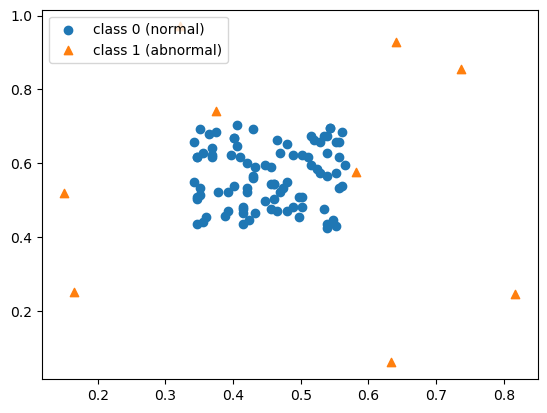

In [147]:
plt.scatter(X_train[y_train == 0, 0],
            X_train[y_train == 0, 1],
            marker='o',
            label='class 0 (normal)')

plt.scatter(X_train[y_train == 1, 0],
            X_train[y_train == 1, 1],
            marker='^',
            label='class 1 (abnormal)')

#plt.xlabel('latency_iotgateway_ms')
#plt.ylabel('latency_logcollector_ms')
#plt.xlabel('packetloss_iotgateway')
#plt.ylabel('packetloss_logcollector')

plt.legend(loc='upper left')

plt.show()

# 7 - Fit k-Nearest Neighbor Model

In [148]:
from sklearn.neighbors import KNeighborsClassifier


knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

# 8 - Use kNN Model to Make Predictions

In [149]:
y_pred = knn_model.predict(X_test)

In [150]:
num_correct_predictions = (y_pred == y_test).sum()
accuracy = (num_correct_predictions / y_test.shape[0]) * 100
print('Test set accuracy: %.2f%%' % accuracy)

Test set accuracy: 95.33%


# 8a - Confusion Matrix

In [151]:

# Confusion Matrix

# A confusion matrix is a table that is often used to describe the performance of a 
# classification model (or "classifier") on a set of test data for which the true values are known.
# Scikit-learn provides facility to calculate confusion matrix using the confusion_matrix method.

#import confusion_matrix
from sklearn.metrics import confusion_matrix

# Evaluate model
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[1907    0]
 [  98   95]]

True Positives(TP) =  1907

True Negatives(TN) =  95

False Positives(FP) =  0

False Negatives(FN) =  98


In [152]:
# Confusion matrix can also be obtained using crosstab method of pandas.
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1907,0,1907
1,98,95,193
All,2005,95,2100


# 8b - Classification Report

In [153]:
# Classification Report

# Another important report is the Classification report. 
# It is a text summary of the precision, recall, F1 score for each class. 
# Scikit-learn provides facility to calculate Classification report using the classification_report method.

In [154]:
#import classification_report
from sklearn.metrics import classification_report

In [155]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1907
           1       1.00      0.49      0.66       193

    accuracy                           0.95      2100
   macro avg       0.98      0.75      0.82      2100
weighted avg       0.96      0.95      0.95      2100



# 9 - Visualize Decision Boundary
You may need to install the mlxtend package. Open a command prompt and run:
conda install mlxtend –channel Conda-forge

In [ ]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X_test, y_test, knn_model)
plt.xlabel('latency_iotgateway_ms')
plt.ylabel('latency_logcollector_ms')
plt.legend(loc='upper left')
plt.show()

# Outstanding Questions
- there are a lot of features (columns) in the dataset.  How to avoid overfitting?
- how should axes be labeled on a scatterplot graph if there are more than 2 features?  Is this possible on a 2D graph?
- run the dataset through these 4 models: 2-class KNN, 2-class SVM, 1-class KNN, 1-class SVM
- how to perform 10-fold cross validation?